<a href="https://colab.research.google.com/github/mendezfranco/EA2-CajaDeUtilidades/blob/master/Mendez_Franco_Ejercicio_1_Paralelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introducción**

La sensación térmica es la temperatura basada en un índice de pérdida de calor corporal causado al combinar los valores de temperatura y velocidad del viento. Las primeras fórmulas para medir la sensación térmica se desarrollaron hacia fines de 1930, gracias a los exploradores Paul Siple y Passel. Con base de estudio en zonas polares, advirtieron que la rapidez del congelamiento aumentaba al unir bajas temperaturas con vientos fuertes. Tras años de revisiones, en 2001 científicos lograron cálculos más precisos y crearon una nueva forma de medida tomando como punto de estudio el rostro humano para comprobar la pérdida de calor que experimentaba la piel. Con estos resultados, se armaron tablas parametrizadas y se arribó a una fórmula para obtener una aproximación al valor de sensación térmica: 

>*Ts = 13.12 + 0.6215 [T] -11.37 [V^0.16] + 0.3965 [T] [V^0.16]*.

El siguiente ejercicio tiene como fin llevar a cabo los cálculos que permitan obtener la sensación térmica, apoyándonos en la potencia de cálculo de GPGPU. Para ello, se simularán los datos de Temperatura (en ºC) y Velocidad del Viento (en km/h) en dos vectores separados. Cada posición de estos vectores hará referencia a una ciudad/localidad específica. Por ejemplo: los valores almacenados en *valores_temperatura[0]* y *valores_viento[0]*, hacen referencia a la temperatura y velocidad del viento en la ciudad con Id 0, y así sucesivamente. Estos dos vectores serán procesados luego por diferentes threads de GPU que se encargarán de efectuar individualmente el cálculo necesario para la obtención de la sensación térmica en determinada ciudad, almacenando el resultado que cada uno obtenga en la posición respectiva del vector de *st*.
Inicialmente, se debe ingresar la cantidad de posiciones, es decir, la cantidad de ciudades o localidades como parámetro. El algoritmo luego completará los vectores de temperatura y velocidad con datos aleatorios. Cabe destacar que una mejora a este ejercicio podría ser obtener desde alguna fuente oficial los valores fehacientes.


---



**2. Armado del Ambiente**

Previo a la ejecución del algoritmo, se debe instalar en Colab el módulo CUDA para python: pycuda. Pycuda es una librería que permite obtener acceso a la API de computación y procesamiento en paralelo CUDA de Nvidia para desarrolladores de python. 




In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 8.8MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=31879d7c65efadbaf586f6ecd9c5e0dc1db4153ff896fc39d631048b99341470
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=99c89dad1e946f89bf349cae92475b5226720ddb38921bbd51d5b00971a5b592
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools




---



**3. Desarrollo**

A continuación se codifican las funcionalidades para cumplir con el objetivo del ejercicio.


In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

cantidad_ciudades = 7000#@param {type: "number"}

# --------------------------------------------

# Agrego los las bibliotecas necesarias
from datetime import datetime
from random import randint

tiempo_total = datetime.now()

import numpy as np
import sys

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# --------------------------------------------
# CPU - Defino la memoria de los vectores en cpu.
valores_temperatura_cpu = [randint(-20,40) for i in range(cantidad_ciudades)]
valores_viento_cpu = [randint(0,40) for j in range(cantidad_ciudades)]

valores_temperatura_cpu = np.array(valores_temperatura_cpu)
valores_temperatura_cpu = valores_temperatura_cpu.astype(np.float32)

valores_viento_cpu = np.array(valores_viento_cpu)
valores_viento_cpu = valores_viento_cpu.astype(np.float32)

st_cpu = np.empty_like(valores_temperatura_cpu)

temp = 0
viento = 0

# CPU - reservo la memoria GPU.
valores_temperatura_gpu = cuda.mem_alloc( sys.getsizeof(valores_temperatura_cpu))
valores_viento_gpu = cuda.mem_alloc( sys.getsizeof(valores_viento_cpu) )
st_gpu = cuda.mem_alloc( st_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( valores_temperatura_gpu, valores_temperatura_cpu )
cuda.memcpy_htod( valores_viento_gpu, valores_viento_cpu )
cuda.memcpy_htod( st_gpu, st_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_obtener_st( int n, float *T, float *V, float *ST)
{
  int idx = (blockIdx.x * blockDim.x) + threadIdx.x;
  
  if( idx < n )
  {
    ST[idx]= 13.12+0.6215*T[idx]-11.37*(pow(V[idx],0.16))+0.3965*T[idx]*(pow(V[idx],0.16));//T[idx]+V[idx];
  }
}
""") 
# CPU - Genero la función kernel.
kernel = module.get_function("kernel_obtener_st")

tiempo_gpu = datetime.now()

# GPU - Ejecuta el kernel.
dim_hilo = 256
dim_bloque = np.int( (cantidad_ciudades+dim_hilo-1) / dim_hilo )

kernel( np.int32(cantidad_ciudades), valores_temperatura_gpu, valores_viento_gpu, st_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

tiempo_gpu = datetime.now() - tiempo_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( st_cpu, st_gpu )

tiempo_total = datetime.now() - tiempo_total

print("Valores de Temperatura")
print(valores_temperatura_cpu)
print("")

print("Valores de Velocidad del Viento")
print(valores_viento_cpu)
print("")

print("Valores de Sensación Térmica")
print(st_cpu)
print("")

print("Tiempos Totales:")
print("Tiempo CPU: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU: ", tiempo_en_ms( tiempo_gpu   ), "[ms]" )

Valores de Temperatura
[ 30.  28.   1. ... -17. -14. -13.]

Valores de Velocidad del Viento
[19.  0. 15. ...  2. 13. 12.]

Valores de Sensación Térmica
[ 32.60593   30.522     -3.183153 ... -17.680128 -21.087858 -19.551697]

Tiempos Totales:
Tiempo CPU:  19.171 [ms]
Tiempo GPU:  0.165 [ms]


**4. Tabla de Pasos**

Resumen de las funciones principales del desarrollo

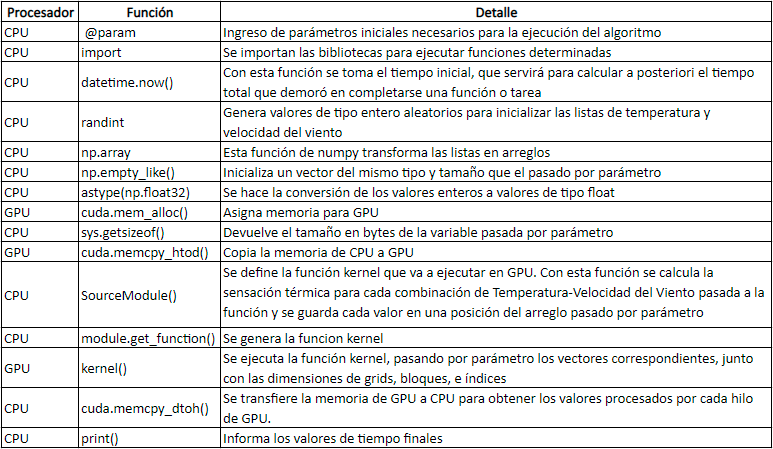


**5. Conclusiones**

*Repaso*

Como vemos, la versión del algoritmo anterior ejecutado sobre GPU en paralelo conlleva una enorme diferencia en términos de velocidad y performance. A través de la función kernel, se pudo asignar a cada thread de GPU una porción de trabajo (que consiste en calcular el valor de sensación térmica para un único par de valores (temperatura;velocidad del viento), y volcarlo en el arreglo de resultado). Así, la carga de trabajo se distribuye ahora entre varios threads que procesarán los datos en forma paralela. Como resultado, la velocidad total se reduce en un 75% aproximadamente. Cabe destacar que estos resultados se hacen más notorios a medida que aumenta la cantidad de ciudades que inicialmente se ingresan por parámetro, lo cual aumenta la cantidad de trabajo a ejecutar, haciendo evidente la alta performance que brinda el procesamiento sobre GPU en paralelo en relación al procesamiento secuencial.


*Lecciones Aprendidas*

En el desarrollo de este primer ejercicio de procesamiento paralelo con GPU, pude comenzar a introducirme en los conceptos básicos de CUDA, el procesamiento paralelo, la forma en que se pueden ejecutar cargas de trabajo sobre una GPU, dimensiones, bloques e hilos. Como resultado, se pudo obtener una aproximación al concepto de computación de propósito general en unidades de procesamiento gráfico (GPGPU).

*Sugerencias para continuar con el ejercicio, mejoras*

Como se enunció en el apartado de Introducción se podría sugerir una mejora para continuar con el ejercicio, que consista en la obtención de estos datos de temperatura y velocidad del viento desde un servicio externo (tal como el Servicio Meteorológico Nacional), para organizarlos en los arreglos correspondientes y así automatizar el cálculo de los valores de sensación térmica en un rango de provincias / ciudades / localidades. Por ejemplo, se podrían obtener a cada hora, los valores de temperatura y viento de las 553 localidades de la Provincia de Buenos Aires y luego almacenar estos datos en los arreglos correspondientes, para así obtener de forma ágil la sensación térmica en cada localidad.

**6. Bibliografía**

[1] CUDA Thread Indexing: [WEB](https://blog.usejournal.com/cuda-thread-indexing-fb9910cba084)

[2] Documentación de biblioteca PYCUDA: [WEB](https://documen.tician.de/pycuda/index.html)

[3] GPU Metaprogramming using PyCUDA
(Methods & Applications):
[PDF](https://www.nvidia.com/content/GTC/documents/1400_GTC09.pdf)

[4] Five different ways to sum vectors in PyCUDA: [WEB](https://medium.com/@CIulius/five-different-ways-to-sum-vectors-in-pycuda-3f2d9409b139)
